In [1]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sys; sys.path.insert(0,"/projects/leelab3/hughchen/shap")
import shap
import numpy as np
import pickle
import matplotlib.pylab as plt
from scipy import stats

In [5]:
task = ['all-cause', 'neoplasms', 'circulatory', 'respiratory', 'digestive', 'other']
random_state = 528
age_feature = 'Age'
for i in range(len(task)):
    if i == 0:
        data = pd.read_csv('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+task[i]+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/different_age_background/'+task[i]+'_SHAP_age.csv')
        data = data.rename({'shap_age': task[i]+'_shap_age'}, axis=1)
        print(data.shape)
    else:
        temp = pd.read_csv('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+task[i]+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/different_age_background/'+task[i]+'_SHAP_age.csv')
        temp = temp.rename({'shap_age': task[i]+'_shap_age'}, axis=1)
        print(temp.shape)
        data = pd.merge(data, temp, on=['eid', age_feature, '31-0.0'], how='right')

(502454, 4)
(502454, 4)
(502454, 4)
(502454, 4)
(502454, 4)
(502454, 4)


In [6]:
print(data.shape)
data = data.dropna()
print(data.shape)

(502454, 9)
(502453, 9)


In [7]:
task = ['all-cause', 'neoplasms', 'circulatory', 'respiratory', 'digestive', 'other']
for i in range(len(task)):
    data[task[i]+'_shap_age_acc'] = data[task[i]+'_shap_age']-data[age_feature]

In [8]:
data.columns

Index(['eid', 'Age', '31-0.0', 'all-cause_shap_age', 'neoplasms_shap_age',
       'circulatory_shap_age', 'respiratory_shap_age', 'digestive_shap_age',
       'other_shap_age', 'all-cause_shap_age_acc', 'neoplasms_shap_age_acc',
       'circulatory_shap_age_acc', 'respiratory_shap_age_acc',
       'digestive_shap_age_acc', 'other_shap_age_acc'],
      dtype='object')

In [9]:
geo_feature = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted_geo.csv').loc[:, ['eid', '54-0.0']]
data = pd.merge(data, geo_feature, on=['eid'], how='left')

In [10]:
X_geo = data.loc[(data['54-0.0']==11004) | (data['54-0.0']==11005)].reset_index(drop=True)
data = data.loc[(data['54-0.0']!=11004) & (data['54-0.0']!=11005)].reset_index(drop=True)

In [68]:
gender = 'female'
gender_index = 1
X = data.loc[data['31-0.0']==gender_index, ['neoplasms_shap_age',
       'circulatory_shap_age', 'respiratory_shap_age',
       'digestive_shap_age', 'other_shap_age']]
y = data.loc[data['31-0.0']==gender_index, 'all-cause_shap_age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

age_train, age_test, _, _ = train_test_split(np.array(data.loc[data['31-0.0']==gender_index, 'Age']), np.array(data.loc[data['31-0.0']==gender_index, 'Age']), test_size=0.2, random_state=7)

xlf = xgboost.XGBRegressor(learing_rate=0.01, n_estimators=1000)
xlf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=100, verbose=False)
model_train_age = xlf
pickle.dump(model_train_age, open('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/model_'+gender+'.pickle.dat', "wb"))

[23:09:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [69]:
print('R square', r2_score(y_test, model_train_age.predict(X_test)))
print(stats.spearmanr(y_test, model_train_age.predict(X_test)))

R square 0.9721566183340724
SpearmanrResult(correlation=0.9875995401108939, pvalue=0.0)


In [70]:
print('R square', r2_score(X_geo.loc[X_geo['31-0.0']==gender_index, 'all-cause_shap_age'], model_train_age.predict(X_geo.loc[X_geo['31-0.0']==gender_index, ['neoplasms_shap_age',
       'circulatory_shap_age', 'respiratory_shap_age',
       'digestive_shap_age', 'other_shap_age']])))
print(stats.spearmanr(X_geo.loc[X_geo['31-0.0']==gender_index, 'all-cause_shap_age'], model_train_age.predict(X_geo.loc[X_geo['31-0.0']==gender_index, ['neoplasms_shap_age',
       'circulatory_shap_age', 'respiratory_shap_age',
       'digestive_shap_age', 'other_shap_age']])))

R square 0.9801483845042666
SpearmanrResult(correlation=0.9907610924830864, pvalue=0.0)


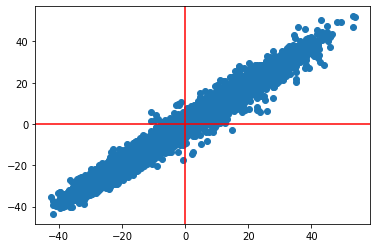

In [14]:
plt.scatter(y_test-age_test, model_train_age.predict(X_test)-age_test)
plt.axhline(0, color='red')
plt.axvline(0, color='red')

In [15]:
features = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted_geo.csv')
label_df = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label_new.csv')
data_mortality = pd.merge(features, label_df[['eid', 'external']], how='left', on='eid')

In [16]:
age = 65
gender = 'female'
gender_index = 0
age_feature = 'Age'
gender_feature = '31-0.0'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/'
task = ['all-cause', 'neoplasms', 'circulatory', 'respiratory', 'digestive', 'other']
X_back = pd.read_csv(path+'X_back'+'_'+gender+'_'+str(age)+'.csv')
X_fore = pd.read_csv(path+'X_single'+'_'+gender+'_'+str(age)+'.csv')
mortality_pre_back = {}
mortality_pre_fore = {}
expect_age_back = {}
expect_age_fore = {}
for t in task:
    path_age = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+t+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'
    model_train = pickle.load(open(path_age+'/model.pickle.dat', "rb"))
    shap_age_obj = pickle.load(open(path_age+'/different_age_background/'+gender+'/SHAP_age_exponential/shap_age_object.pkl', "rb"))
    X_back = X_back[model_train.get_booster().feature_names]
    X_fore = X_fore[model_train.get_booster().feature_names]
    mortality_pre_back[t] = model_train.predict(X_back.loc[X_back[gender_feature]==gender_index, :], output_margin=True)
    mortality_pre_fore[t] = model_train.predict(X_fore.loc[X_fore[gender_feature]==gender_index, :], output_margin=True)
    expect_age_back[t] = shap_age_obj.get_shap_age(mortality_pre_back[t])
    expect_age_fore[t] = shap_age_obj.get_shap_age(mortality_pre_fore[t])

In [17]:
shap_values_single = {}
shap_values_single_mean = {}
for t in task:
    shap_values_single[t] = np.load(path+'shap_values_single_'+t+'_'+gender+'_'+str(age)+'.npy')
    shap_values_single_mean[t] = shap_values_single[t].mean(2)

In [18]:
model_train_age = pickle.load(open('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/model_'+gender+'.pickle.dat', "rb"))
back_data_age = pd.DataFrame()
fore_data_age = pd.DataFrame()
for t in task:
    if t == 'all-cause':
        continue
    back_data_age[t+'_shap_age'] = expect_age_back[t]
    fore_data_age[t+'_shap_age'] = expect_age_fore[t]
explainer_age = shap.TreeExplainer(model_train_age, data=back_data_age)
shap_values_age = explainer_age.shap_values(fore_data_age, per_reference=True)
np.save('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/shap_values_age_pre_'+gender+'_'+str(age)+'.npy', shap_values_age)

[16:04:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Passing 8612 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 199/200 [01:57<00:00]        

In [19]:
task = ['all-cause', 'neoplasms', 'circulatory', 'respiratory', 'digestive', 'other']
fore_final_attr_dict = {}
for i in range(len(task)):
    if i == 0:
        continue
    fore_attr_defa = shap_values_single[task[i]].mean(2)
    fore_attr_per_ref = shap_values_single[task[i]]
    fore_attr_per_ref = np.swapaxes(fore_attr_per_ref,1,2)     # Re-order axes 
    fore_lodd_pred = mortality_pre_fore[task[i]]
    back_lodd_pred = mortality_pre_back[task[i]]
#     assert(np.allclose(fore_attr_defa.sum(1), fore_lodd_pred-back_lodd_pred.mean(), atol=1e-3))
    # Function of the model prediction applied to fore_data_temp and back_data_temp (used for rescale rule)
    # Get the factor by which we rescale the per back_data_temp attributions
    denom    = fore_lodd_pred[:,None] - back_lodd_pred[None,:]
    # numer    = shap_values_age[:, i, :]
    numer    = shap_values_age[:, i-1, :]
    safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0) # Divide by zero gives zero
    rescale  = safe_div(numer, denom)        # Rescale factor based on func_lodds
    # Do the final rescaling
    final_attr = fore_attr_per_ref * rescale[:,:,None] # The final, rescaled attribution
    fore_final_attr_dict[task[i]] = final_attr.mean(1)
pickle.dump(fore_final_attr_dict, open('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/shap_values_tasks_rescaled_dict_'+gender+'_'+str(age)+'.pkl', 'wb'))

In [20]:
file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_fore.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [21]:
sample = 125
num_features = 5
for t in task:
    print(t)
    print(expect_age_fore[t][sample])
print(shap_values_age.mean(2)[sample])
print(explainer_age.expected_value)
print('EXPECT Age: ', model_train_age.predict(pd.DataFrame(np.array(fore_data_age), columns=model_train_age.get_booster().feature_names))[sample])
print('sum of SHAP values of age prediction', explainer_age.expected_value+sum(shap_values_age.mean(2)[sample]))

all-cause
76.169334
neoplasms
78.92645
circulatory
70.70494
respiratory
73.33235
digestive
88.18953
other
69.18547
[5.92884787 0.89857851 0.43270443 2.65236798 0.6421601 ]
64.69142993077746
EXPECT Age:  75.24606
sum of SHAP values of age prediction 75.24608881305412


## paper plotting

In [22]:
def convert_shap_values_SameAge(shap_age_obj, shap_values_all_dict, fore_prediction, back_prediction):
    print('Starting converting SHAP values')
    fore_attr_defa = shap_values_all_dict.mean(2)
    fore_attr_per_ref = shap_values_all_dict
    fore_attr_per_ref = np.swapaxes(fore_attr_per_ref,1,2)                           # Re-order axes 
    fore_lodd_pred = fore_prediction
    back_lodd_pred = back_prediction

    fore_func_pred = shap_age_obj.get_shap_age(fore_lodd_pred)
    back_func_pred = shap_age_obj.get_shap_age(back_lodd_pred)
    fore_shap_age = fore_func_pred
    back_shap_age = back_func_pred
    # Get the factor by which we rescale the per back_data_temp attributions
    denom    = fore_lodd_pred[:,None] - back_lodd_pred[None,:]
    numer    = fore_func_pred[:,None] - back_func_pred[None,:]
    safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0) # Divide by zero gives zero
    rescale  = safe_div(numer, denom)        # Rescale factor based on func_lodds
    # Do the final rescaling
    final_attr = fore_attr_per_ref * rescale[:,:,None] # The final, rescaled attribution
    fore_final_attr = final_attr.mean(1)
    return fore_final_attr

In [23]:
t = 'all-cause'
path_age = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+t+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'
model_train = pickle.load(open(path_age+'/model.pickle.dat', "rb"))
shap_age_obj = pickle.load(open(path_age+'/different_age_background/'+gender+'/SHAP_age_exponential/shap_age_object.pkl', "rb"))
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/'
X_back = pd.read_csv(path+'X_back'+'_'+gender+'_'+str(age)+'.csv')[model_train.get_booster().feature_names]
explainer = shap.TreeExplainer(model_train, data=X_back)
shap_values_all_cause_rescaled = convert_shap_values_SameAge(shap_age_obj, shap_values_single[t], mortality_pre_fore[t], mortality_pre_back[t])

Starting converting SHAP values


In [24]:
file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_fore.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [25]:
for col in col_dict:
    if 'Age at cancer' in col_dict[col]:
        print(col)

40008-0.0
40008-0.0_1


In [26]:
X_fore[X_fore['40008-0.0']!=-1].index

Int64Index([  3,   7,   8,   9,  12,  29,  32,  39,  50,  69,  78,  83,  91,
             95,  97, 105, 111, 114, 117, 131, 135, 142, 154, 160, 161, 164,
            171, 183],
           dtype='int64')

In [27]:
X_fore[X_fore['40008-0.0']==-1].index

Int64Index([  0,   1,   2,   4,   5,   6,  10,  11,  13,  14,
            ...
            190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
           dtype='int64', length=172)

In [28]:
X_fore[(shap_values_single['all-cause'].mean(2).sum(axis=1)>-0.1) & (shap_values_single['all-cause'].mean(2).sum(axis=1)<0.1)].index

Int64Index([  9,  35,  41,  47,  50,  52,  54,  72,  84,  87,  91, 106, 108,
            109, 120, 121, 130, 145, 152, 165, 167, 173, 189, 195, 196],
           dtype='int64')

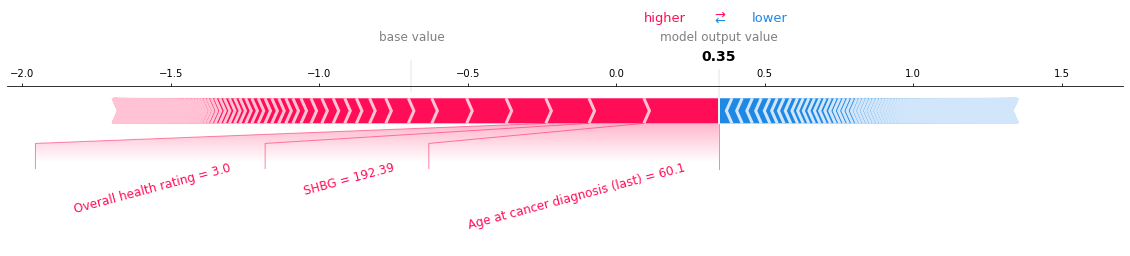

In [53]:
i = 160
# 65:
# concept_figure: 72
# good: 73 (all-cause, neoplasms), 51, 53, 10 (all-cause, neoplasms), 11 (all-cause, neoplasms), *14* (all-cause, neoplasms)
# medium: 0, 7, 12, 23, 39, *72*
# bad: *160* (all-cause, neoplasms), 64 (all-cause, neoplasms), 59 (all-cause, neoplasms), 33 (all-cause, neoplasms), 3, 8 (all-cause, neoplasms)
shap.force_plot(explainer.expected_value, shap_values_single[t].mean(2)[i], X_fore.loc[i, :], feature_names=display_col, matplotlib=True, show=True, text_rotation=375)

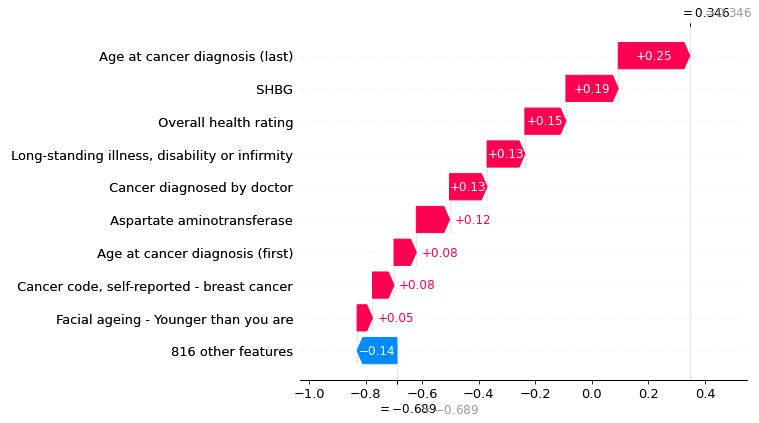

In [54]:
shap.waterfall_plot(explainer.expected_value, shap_values_single[t].mean(2)[i], features=X_fore.loc[i, :], feature_names=display_col, show=False)
# plt.savefig('./result/paper_figures/UKB_shap_waterfall_plot'+'_'+t+'_'+gender+'_'+str(age)+'_'+str(i)+'_healthy.pdf', format='pdf', bbox_inches='tight')

72.93904


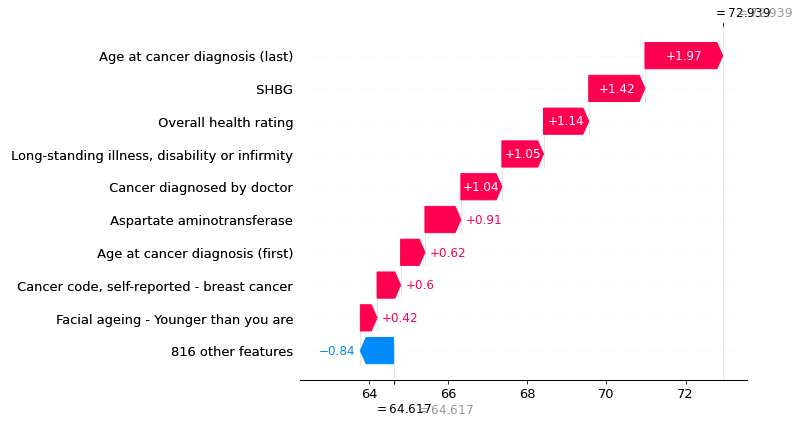

In [55]:
print(expect_age_fore[t][i])
shap.waterfall_plot(expect_age_back[t].mean(), shap_values_all_cause_rescaled[i], features=X_fore.loc[i, :], feature_names=display_col, show=False)
# plt.savefig('./result/paper_figures/UKB_age_waterfall_plot'+'_'+t+'_'+gender+'_'+str(age)+'_'+str(i)+'_healthy.pdf', format='pdf', bbox_inches='tight')

In [56]:
print('positive SHAP_values: ', np.array(display_col)[np.argsort(-shap_values_single['all-cause'].mean(2)[i])][:10])
print('positive features: ', np.array(X_fore.loc[i, :])[np.argsort(-shap_values_single['all-cause'].mean(2)[i])][:10])
print('negative SHAP_values: ', np.array(display_col)[np.argsort(shap_values_single['all-cause'].mean(2)[i])][:10])
print('negative features: ', np.array(X_fore.loc[i, :])[np.argsort(shap_values_single['all-cause'].mean(2)[i])][:10])     

positive SHAP_values:  ['Age at cancer diagnosis (last)' 'SHBG' 'Overall health rating'
 'Long-standing illness, disability or infirmity'
 'Cancer diagnosed by doctor' 'Aspartate aminotransferase'
 'Age at cancer diagnosis (first)'
 'Cancer code, self-reported - breast cancer'
 'Facial ageing - Younger than you are' 'Waist circumference']
positive features:  [ 60.1  192.39   3.     1.     1.    69.8   60.1    1.     0.   107.  ]
negative SHAP_values:  ['Past tobacco smoking'
 'Histology of cancer tumour - (8010-8790) Epithelial'
 'Alanine aminotransferase' 'Country of birth (UK/elsewhere) - England'
 'Age' 'Knee pain for 3+ months' 'Platelet crit' 'Hip circumference'
 'IGF-1'
 'Illness, injury, bereavement, stress in last 2 years - Serious illness, injury or assault to yourself']
negative features:  [  4.           1.          33.79         0.          64.75890411
   1.           0.263      125.          11.887        0.        ]


In [57]:
X_fore.loc[i, :]

4096-0.0_1     0.0
6144-0.0_4     0.0
6144-0.0_1     0.0
6144-0.0_2     0.0
2050-0.0       1.0
              ... 
40012-0.0_1    0.0
40012-0.0_3    1.0
40012-0.0_5    0.0
40012-0.0_6    0.0
40012-0.0_9    0.0
Name: 160, Length: 825, dtype: float64

In [58]:
display_col[811]

'Age at cancer diagnosis (last)'

In [63]:
for k in range(20):
    # print((-np.abs(shap_values_all_cause_rescaled[i])).argsort()[k])
    print(list(X_fore.columns)[(-np.abs(shap_values_all_cause_rescaled[i])).argsort()[k]])
    print(display_col[(-np.abs(shap_values_all_cause_rescaled[i])).argsort()[k]])
    print(X_fore.iloc[i, (-np.abs(shap_values_all_cause_rescaled[i])).argsort()[k]])

40008-0.0_1
Age at cancer diagnosis (last)
60.1
30830-0.0
SHBG
192.39
2178-0.0
Overall health rating
3.0
2188-0.0
Long-standing illness, disability or infirmity
1.0
2453-0.0
Cancer diagnosed by doctor
1.0
30650-0.0
Aspartate aminotransferase
69.8
40008-0.0
Age at cancer diagnosis (first)
60.1
20001-0.0_1002
Cancer code, self-reported - breast cancer
1.0
1757-0.0_1
Facial ageing - Younger than you are
0.0
48-0.0
Waist circumference
107.0
1249-0.0
Past tobacco smoking
4.0
6149-0.0_6
Mouth/teeth dental problems - Dentures
1.0
30110-0.0
Platelet distribution width
17.12
30730-0.0
Gamma glutamyltransferase
55.2
6219-0.0
Impedance of leg, manual entry (right)
159.0
40011-0.0_2
Histology of cancer tumour - (8010-8790) Epithelial
1
6220-0.0
Impedance of leg, manual entry (left)
162.0
30620-0.0
Alanine aminotransferase
33.79
1647-0.0_1
Country of birth (UK/elsewhere) - England
0.0
Age
Age
64.75890410958904


In [49]:
(-np.abs(shap_values_all_cause_rescaled[i])).argsort()

array([811, 797, 109, 114, 160, 804, 810, 483, 649,  83, 355,  32, 760,
       755,  91, 813,  92, 771, 549, 809, 779, 632, 664, 759, 102, 758,
       787, 770,  84, 793, 808, 762, 769, 105, 104, 776,   7, 426, 547,
       714, 310, 641, 635, 164, 796, 761, 530, 781,  98, 778, 228, 541,
       794, 687, 785, 750, 798, 749, 807, 306, 253,  99, 113, 765,  85,
       757, 679, 332,  71, 803, 792, 790, 772, 538, 398, 245, 217, 628,
       116, 805, 795, 768, 631, 274, 791,  82, 821, 786, 100, 312, 276,
       383,  90, 788, 380, 566, 784, 224, 774, 304, 260, 379, 250, 185,
        30, 545, 763, 207, 140, 278, 806, 556, 799,  96, 406, 305, 751,
        65, 773, 255,  66, 133,   1,  97,  11, 427, 126, 712, 675, 154,
       106, 112, 431, 800, 252, 111, 314, 422,  94, 775, 767, 801, 307,
        14, 780, 420, 119, 236, 275, 435, 152, 151, 441, 289, 440, 648,
       374, 302, 442, 764, 193,  81, 286, 623, 219, 235, 704, 783, 166,
       617, 389, 101, 607, 782,   5, 553, 361, 381, 616, 372, 54